# Anomaly Detection with the RBM

Boltzmann machine is a special type of bidirectional neural network comprised
only of hidden nodes and input nodes, designed to learn the probability distribution of a data set. What makes a Boltzmann machine special is that each and every node is interconnected to each other, meaning the neurons in the hidden layer are connected to each other as well.

the Boltzmann machine has fixed weights, and the nodes make stochastic (probabilistic) decisions about whether or not to fire.

# Restricted Boltzmann Machine (RBM)

The RBM is similar to the Boltzmann machine in that it is an unsupervised, stochastic (probabilistic), generative deep learning model.

Because we place a restriction on the layers that none of the nodes within their own layer are to be interconnected, the model is termed as a restricted Boltzmann machine

Bias a adds to all of the outputs of the input layer, and bias b adds to the outputs of the hidden layer. From here, we can define what is called the energy function, which the RBM tries to minimize. 

the RBM is a probabilistic model that operates in accordance with a set of formulas. Additionally, the goal of the formulas is to help the RBM learn a probability distribution to represent V, explaining why the RBM is an unsupervised learning algorithm.

As for the training algorithm, there are two choices: contrastive divergence (CD) and persistent contrastive divergence (PCD). These algorithms both use Markov chains to help the training algorithm determine what direction to perform the gradient calculations in, but both differ and have their pros and cons. PCD can get better samples of the data and explore the domain of the input space better, but CD is better at extracting features.

While the large amount of zero-value entries might not have affected the isolation forest, they will certainly mess with the training process of the RBM, leading to terrible AUC scores. Therefore, standardizing all of the values will help the RBM during the training process and help it attain proper AUC scores

# Library

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score as auc 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe,scoring,RBM

%reload_ext autoreload

# Load data

In [3]:
filePath = f'E:/gitlab/machine-learning/dataset/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()

284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# scaling

In [4]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

# split data

In [5]:
x_train = df.iloc[:200000, 1:-2].values
y_train = df.iloc[:200000, -1].values

x_test = df.iloc[200000:, 1:-2].values
y_test = df.iloc[200000:,-1].values

print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))

Shapes:
x_train:(200000, 28)
y_train:(200000,)

x_test:(84807, 28)
y_test:(84807,)



# Model

In [6]:
model = RBM(x_train.shape[1], 10, visible_unit_type='gauss', main_dir='./', model_name='rbm_model.ckpt',
                 gibbs_sampling_steps=4, learning_rate=0.001, momentum = 0.95, batch_size=512, num_epochs=20, verbose=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Validation cost at step 0: 0.970529
Validation cost at step 1: 0.8929105
Validation cost at step 2: 0.87029386
Validation cost at step 3: 0.8689252
Validation cost at step 4: 0.86232424
Validation cost at step 5: 0.8541864
Validation cost at step 6: 0.85129595
Validation cost at step 7: 0.8567492
Validation cost at step 8: 0.8459958
Validation cost at step 9: 0.84902114
Validation cost at step 10: 0.85000837
Validation cost at step 11: 0.8502719
Validation cost at step 12: 0.8432842
Validation cost at step 13: 0.84697735
Validation cost at step 14: 0.8513798
Validation cost at step 15: 0.8423499
Validation cost at step 16: 0.84463686
Validation cost at step 17: 0.8448843
Validation cost at step 18: 0.84129745
Validation cost at step 19: 0.84403324


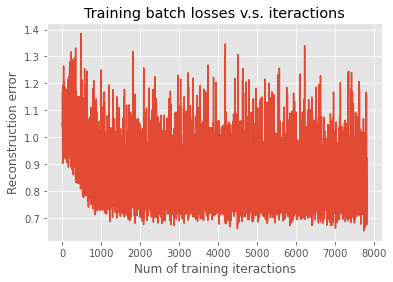

In [7]:
model.fit(x_train, validation_set=x_test)

In [8]:
costs = model.getFreeEnergy(x_test).reshape(-1)
score = auc(y_test, costs)
print("AUC Score: {:.2%}".format(score))

INFO:tensorflow:Restoring parameters from ./rbm_model.ckpt
AUC Score: 95.38%


graph the free energy vs. the probability of each data point to get an
idea of what the anomalies look like compared to the normal data points. 

In [9]:
normal = pd.DataFrame(costs[y_test==0])

In [10]:
describe.describe_num(normal)

,count,mean,std,min,25%,50%,75%,max
0,84700.0,0.729456,87.14463,-7.300965,-5.324947,-3.960501,-1.433006,21824.53125


summary shows that the normal data is right skewed, since the values for each quartile are in the negative, while the outlier values in the tail bring the mean up into the positives

In [11]:
anomaly = pd.DataFrame(costs[y_test==1])
describe.describe_num(anomaly)

,count,mean,std,min,25%,50%,75%,max
0,107.0,88.758545,64.97654,-5.408322,37.590822,96.668518,128.617809,231.609222


it seems that all of the anomalies are below 250. Knowing this, you can now pick a threshold value so only the relevant data is displayed on the graph

let’s choose a cutoff point of 250, since the maximum free energy for an
anomaly is at around 232. 

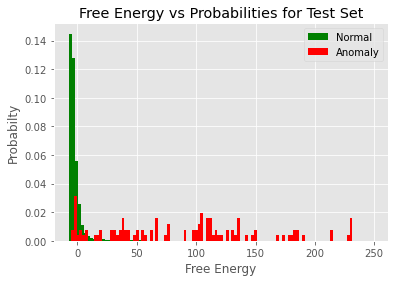

In [12]:
plt.title('Free Energy vs Probabilities for Test Set')
plt.xlabel('Free Energy')
plt.ylabel('Probabilty')
plt.hist(costs[(y_test == 0) & (costs < 250)], bins = 100, color='green', density=True, label='Normal')
plt.hist(costs[(y_test == 1) & (costs < 250)], bins = 100, color='red', density=True, label ='Anomaly')

plt.legend(loc="upper right")
plt.show()